In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [3]:
df = pd.read_csv('data/Daily net retail sales 5 May 2000  6 April 2003.csv', index_col=0)
df['x'].fillna(df['x'].mean(), inplace=True)

### Скользящее среднее

In [4]:
df['MA_window_3'] = df['x'].rolling(window=10).mean()
df

,x,MA_window_3
1,257209.361963,NaN
2,257209.361963,NaN
3,257209.361963,NaN
4,201468.000000,NaN
5,284033.000000,NaN
...,...,...
1063,414697.000000,286650.836196
1064,217567.000000,284935.336196
1065,171781.000000,263797.736196
1066,174159.000000,238374.136196


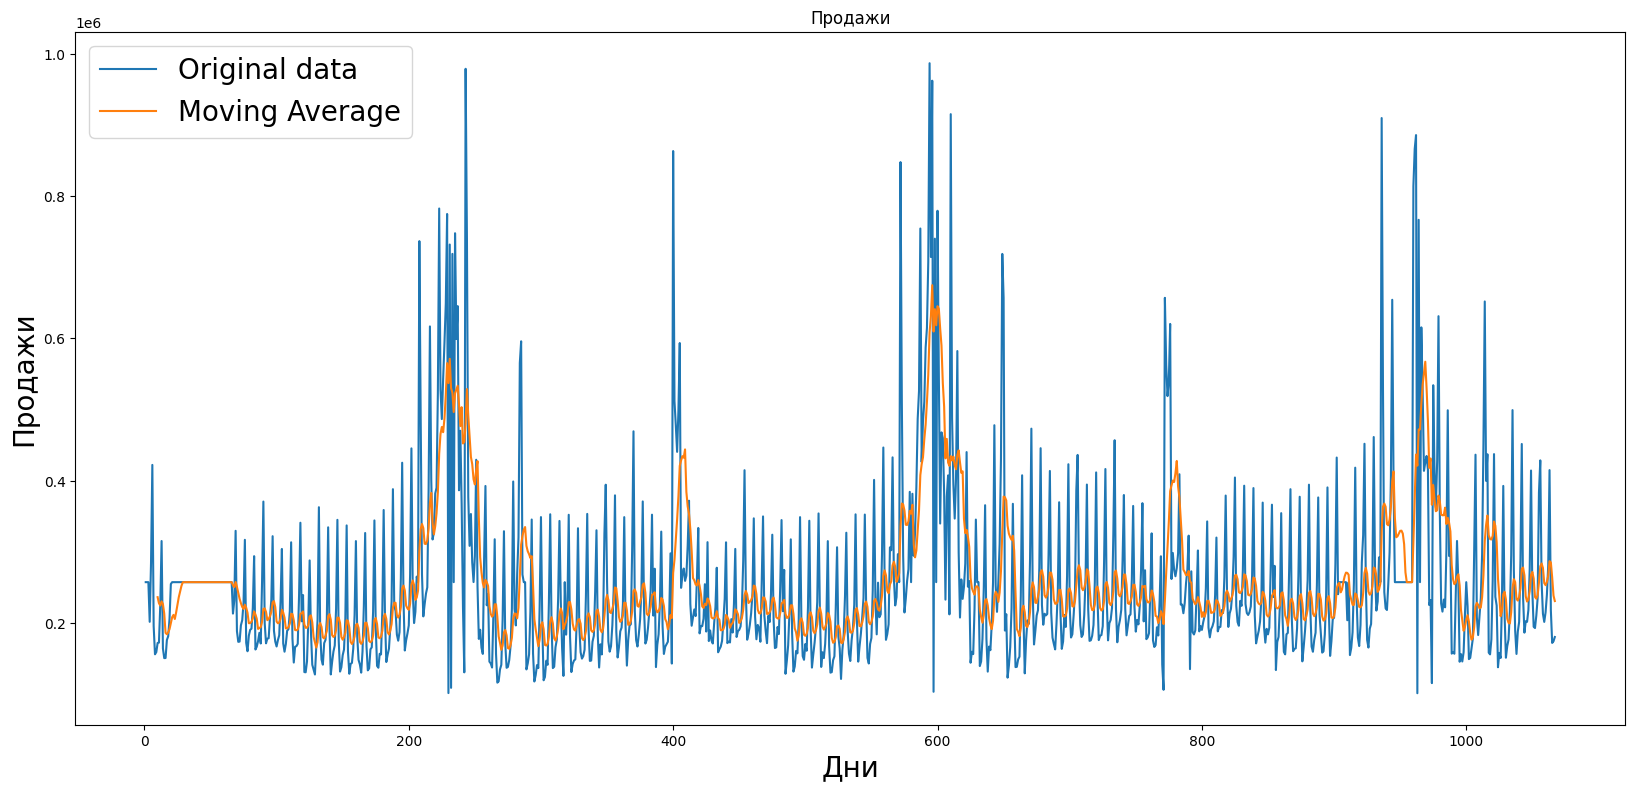

In [5]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Продажи')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

Можно поиграться с размерностью окна

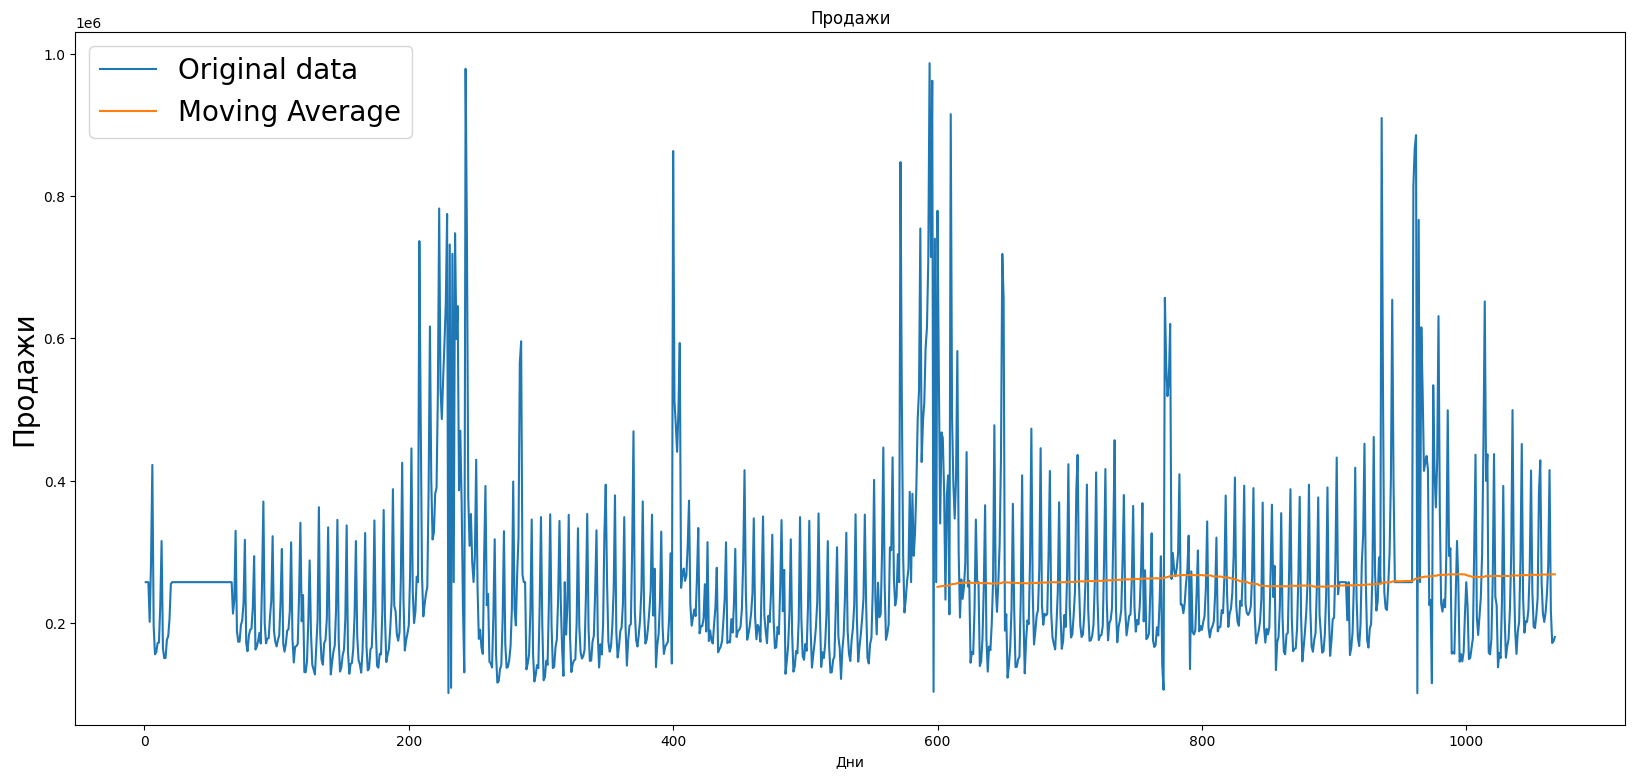

In [6]:
df['MA_window_6'] = df['x'].rolling(window=600).mean()
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_6'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Продажи')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни')
plt.show()


Давайте напишем функцию, которая поможет нам понять тенденцию и движения временного ряда. Мы хотим видеть на графике некоторую скользящую статистику, такую как:

M скользящее среднее: невзвешенное среднее предыдущих n данных (также называемое скользящим средним).

Полосы Боллинджера: верхняя полоса в k раз на n -периодное стандартное отклонение выше скользящей средней и нижняя полоса в k раз на стандартное отклонение N ниже.

In [7]:
'''
Отрисовка скользящего среднего по медиане для ts с 95% доверительным интервалом для стандартного отклонения.
:parameter
  :param ts: датасет
  :param window: кол-во семплов в окне - для скользящих средних
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

C:\Users\Ivan\AppData\Local\Temp\ipykernel_19392\3736708662.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


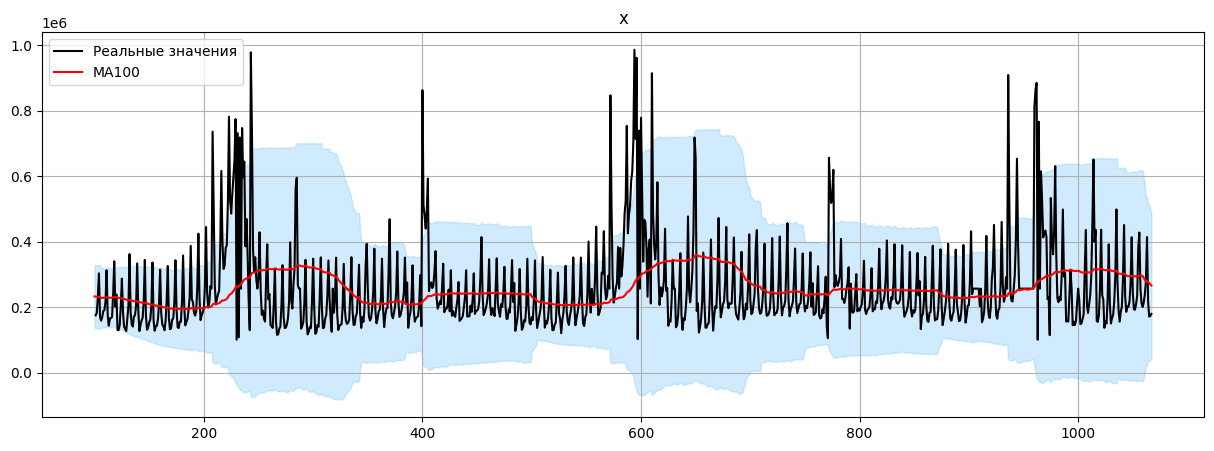

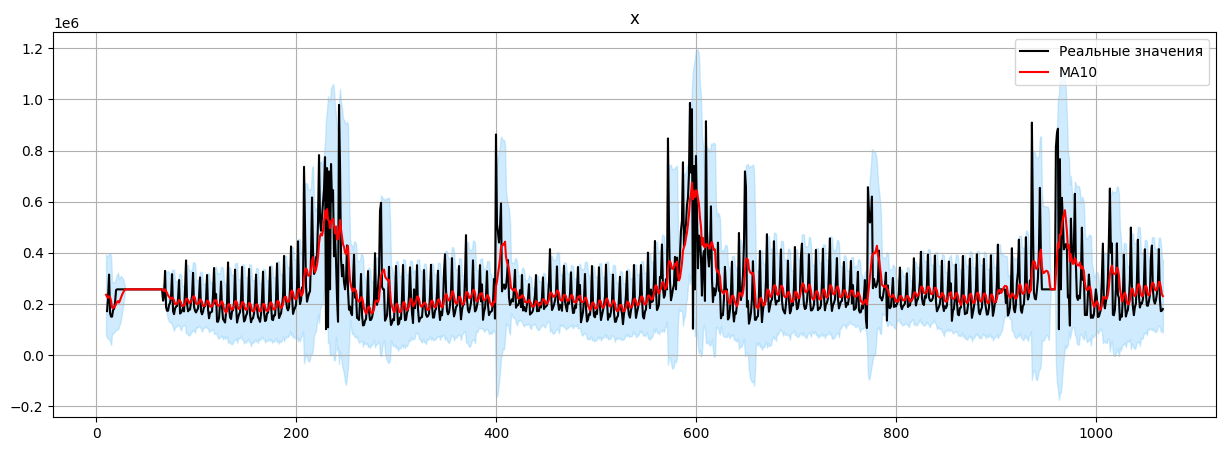

In [8]:
plot_ts(df["x"], window=100)
plot_ts(df["x"], window=10)

### ARMA

In [9]:
from statsmodels.tsa.arima.model import ARIMA

## Предсказание ряда на основе предыдущих значений

### ARIMA  

Модель авторегрессии скользящего среднего и систематический подход к её построению предназначена для анализа стационарных временных рядов на основе оценки линейной зависимости прогнозируемых значений от исторических.

Для использования модели временной ряд должен быть стационарным, т.е. его среднее и дисперсия должны быть постоянны.

Модель Бокса-Дженкинса предполагает, что временной ряд содержит три составляющие: авторегресионную, интегрированную и скользящее среднее, которые в модели обозначены $p$, $d$ и $q$ соответственно:

* Величина $p$ называется порядком авторегрессии. Она позволяет ответить на вопрос, будет ли очередной элемент ряда близок к значению $X$, если к нему были близки $p$ предыдущих значений.
* Величину $d$ называют порядком интегрирования. Она показывает, насколько элемент ряда близок по значению к $d$ предыдущим значениям, если разность между ними минимальна.

* Параметр $q$— порядок скользящего среднего. Позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

Авторегрессия — это составляющая модели временного ряда, в которой его прогнозируемое значение может быть выражено в виде линейной комбинации исторических значений этого же ряда и случайной ошибки.

Обычно модель упоминается, как ARIMA$(p,d,q)$, где $p$, $d$ и $q$ — целые неотрицательные числа, характеризующие порядок для частей модели (соответственно авторегрессионной, интегрированной и скользящего среднего).

Для временного ряда $X(t)$ модель может быть записана в виде:

$$(\delta^dX_t)=\sum^p_{t=1}a_t(\delta^dX_{t-1}) + \epsilon_t + \sum^q_{j=1}b_j(\delta^d\epsilon_{t-j})$$

где

* $\delta^d$ — оператор разности порядка $d$ (последовательное взятие $d$ раз разностей первого порядка — сначала от самого ряда, затем от полученных разностей первого порядка, затем от второго порядка и т. д.);
* $a_t$— коэффициенты авторегрессионной части модели, $\epsilon_t$— значения ошибки (полагаются независимыми одинаково распределёнными случайными величинами из нормального распределения с нулевым средним);
* $b_j$ — коэффициенты скользящего среднего.

Модель Бокса-Дженкинса широко применяются при прогнозировании временных рядов. Основная задача при этом заключается в оценке параметров модели. Методология построения ARIMA-модели исследуемого временного ряда включает следующие основные этапы:

* построение пробной модели;
* оценивание параметров модели и проверка адекватности модели;
* использование модели для прогнозирования.

Чтобы построить модель ARMA, мы можем использовать функцию ARIMA (которая будет
объяснена в следующем разделе) в statsmodels.tsa.arima.model и указать
гиперпараметр — order(p, d, q). Когда d = 0, он работает как модель ARMA.

In [10]:
arma_model = ARIMA(df['x'], order=(5,0,3))
arma_model_fit = arma_model.fit()

c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ivan\Desktop\timeseries_h

In [11]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 1067
Model:                 ARIMA(5, 0, 3)   Log Likelihood              -13867.533
Date:                Mon, 20 Nov 2023   AIC                          27755.067
Time:                        18:58:42   BIC                          27804.793
Sample:                             0   HQIC                         27773.907
                               - 1067                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.572e+05   1.74e+04     14.823      0.000    2.23e+05    2.91e+05
ar.L1         -0.1103      0.039     -2.806      0.005      -0.187      -0.033
ar.L2          0.5518      0.038     14.701      0.0

In [12]:
X = df['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [13]:
print(len(train))
print(len(test))
print(len(arma_predictions))

704
363
363


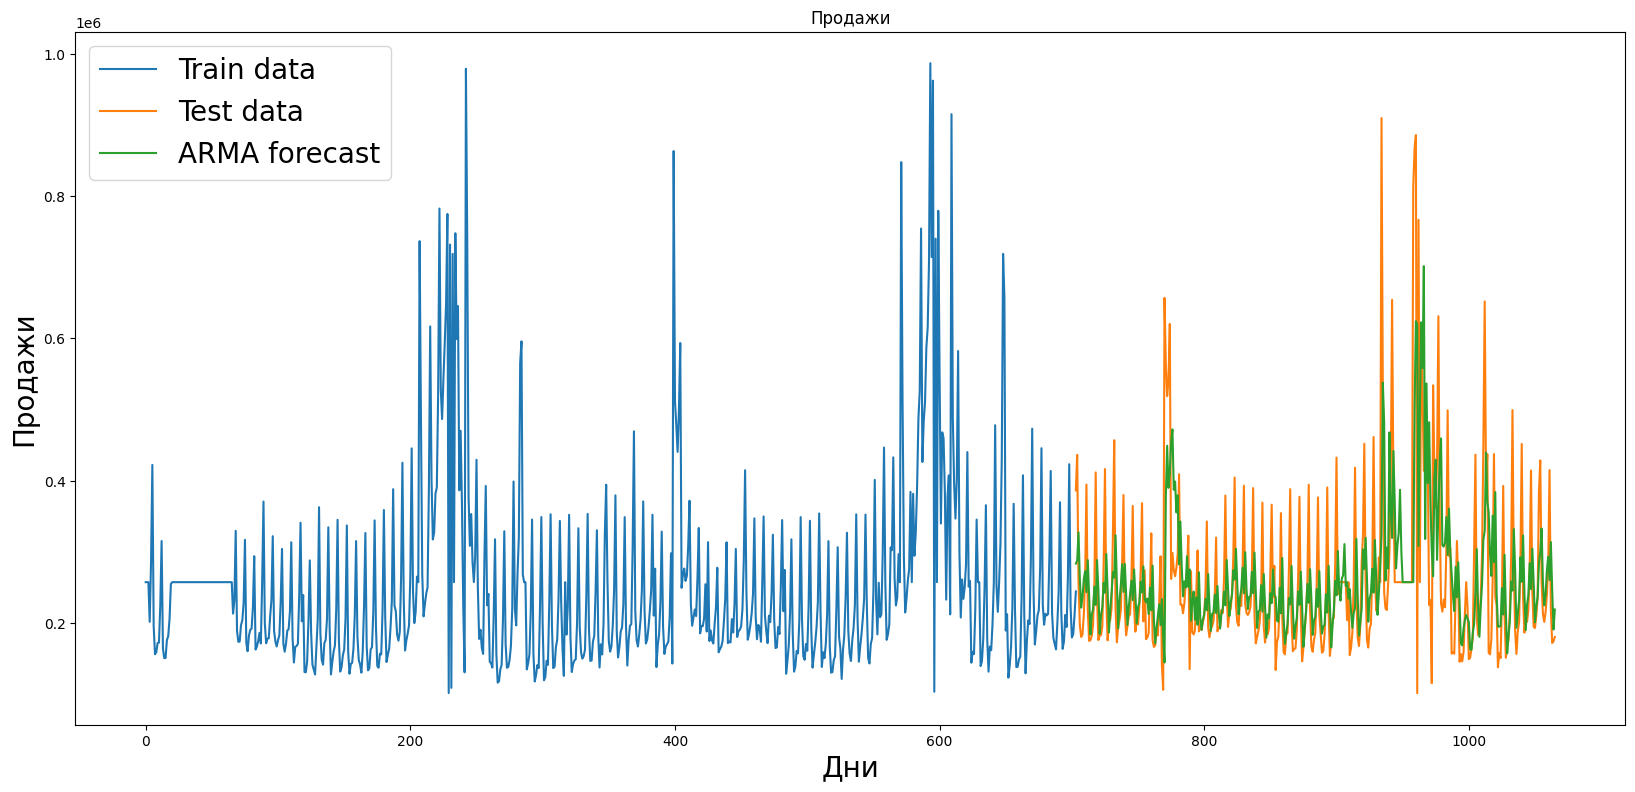

In [14]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Продажи')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

In [24]:
data = pd.read_csv('data/Daily net retail sales 5 May 2000  6 April 2003.csv', index_col=0)
data['x'].fillna(data['x'].mean(), inplace=True)

In [25]:
p_arma_model = ARIMA(data['x'], order=(5,0,3))
p_arma_model_fit = p_arma_model.fit()

c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ivan\Desktop\timeseries_h

In [26]:
from IPython.display import clear_output
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()

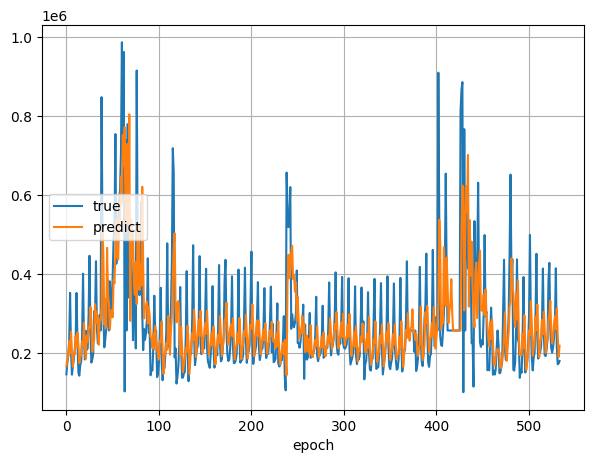

In [27]:
series = data["x"]

size = int(series.shape[0] * 0.5)
train, test = series[:size], series[size:len(series)]
history = [x for x in train.values]
predictions = []

val = {"true":[], "predict":[]}
for t in test.values:
    model = ARIMA(history, order=(5,1,0)).fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    val["predict"].append(yhat)
    val["true"].append(t)
    history.append(t)
    live_plot(val)

In [28]:
X = data['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

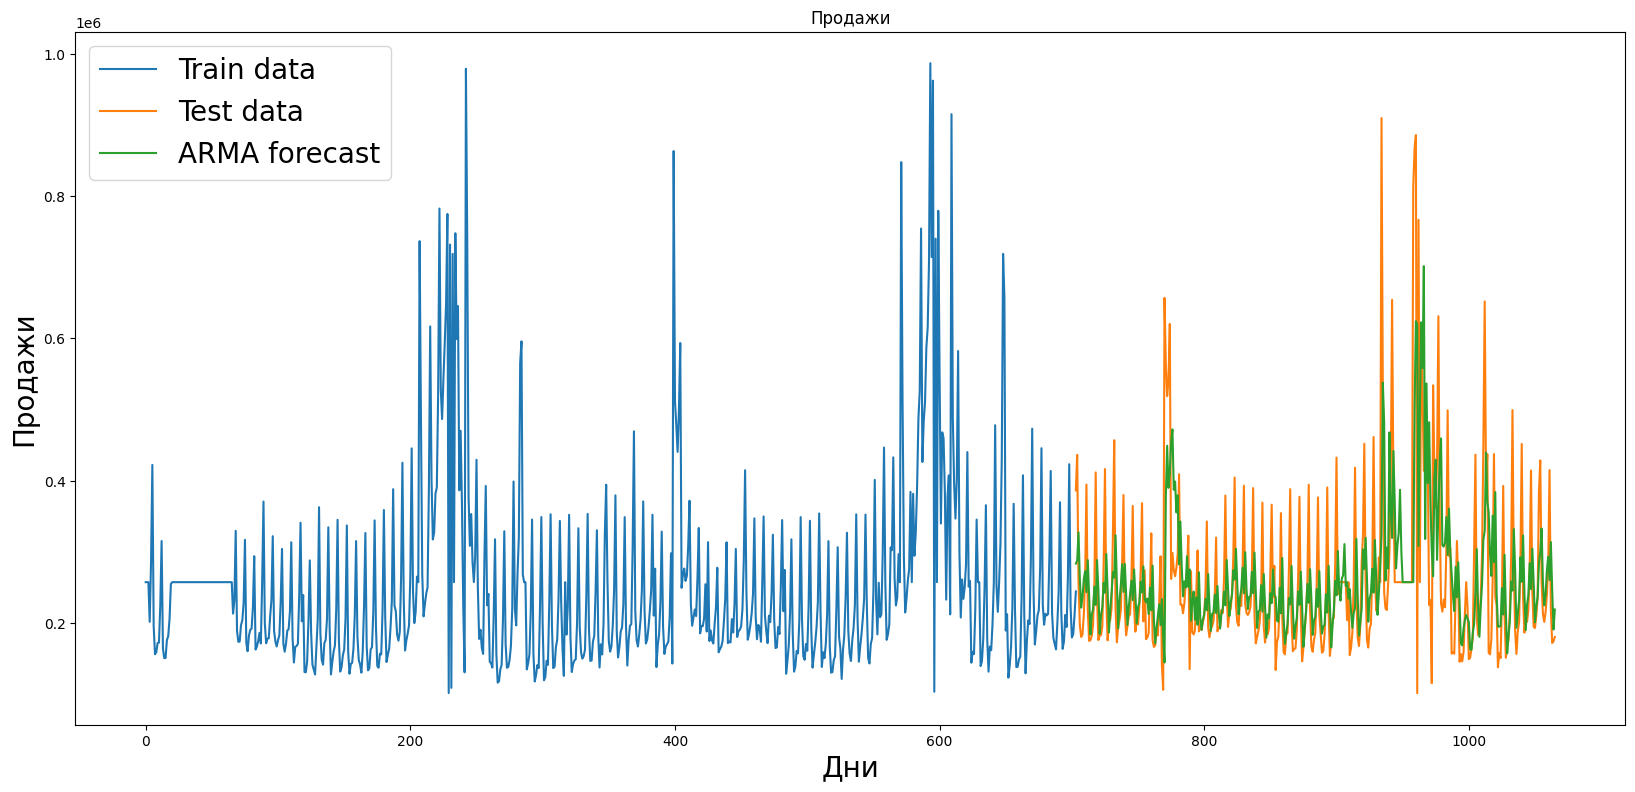

In [29]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Продажи')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

### ARMA Metrics

In [30]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def smape_score(actual, predicted) -> float: 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual)) / 2) 
        ), 3)

In [31]:
print("RMSE:", np.sqrt(mean_squared_error(test, arma_predictions)))
print("MAPE:", mean_absolute_percentage_error(test, arma_predictions))
print("MAE:", mean_absolute_error(test, arma_predictions))
print("R2:", r2_score(test, arma_predictions))
print("SMAPE:", smape_score(test, arma_predictions))

RMSE: 110033.06302732913
MAPE: 0.25723365646293644
MAE: 70206.1776902868
R2: 0.17797257592629345
SMAPE: 0.237


### ARIMA

In [32]:
arima_model = ARIMA(data['x'], order=(10,2,10))
arima_model_fit = arima_model.fit()

c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\l

In [33]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 1067
Model:               ARIMA(10, 2, 10)   Log Likelihood              -13703.223
Date:                Mon, 20 Nov 2023   AIC                          27448.446
Time:                        19:10:37   BIC                          27552.831
Sample:                             0   HQIC                         27487.998
                               - 1067                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7401      0.230     -7.573      0.000      -2.190      -1.290
ar.L2         -1.9467      0.339     -5.745      0.000      -2.611      -1.283
ar.L3         -2.5501      0.409     -6.231      0.0

Полезным может быть получение линейного графика остаточных ошибок, что позволяет предположить, что некоторая информация о тенденциях все еще может быть не учтена моделью.

<Axes: >

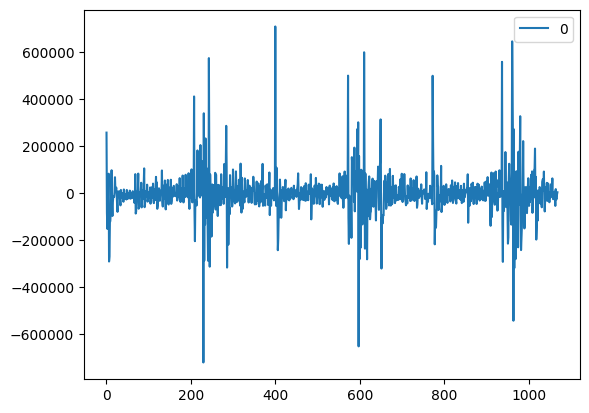

In [34]:
arima_residuals = pd.DataFrame(arima_model_fit.resid)
arima_residuals.plot()

Осуществляем предсказание

In [35]:
# forecast предсказывает только следующее значение
output = arima_model_fit.forecast()

c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
data['x'].fillna(data['x'].mean(), inplace=True)
X = data['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    arima_model = ARIMA(history, order=(10,2,5))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Ivan\Desktop\timeseries_hoomeworks\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


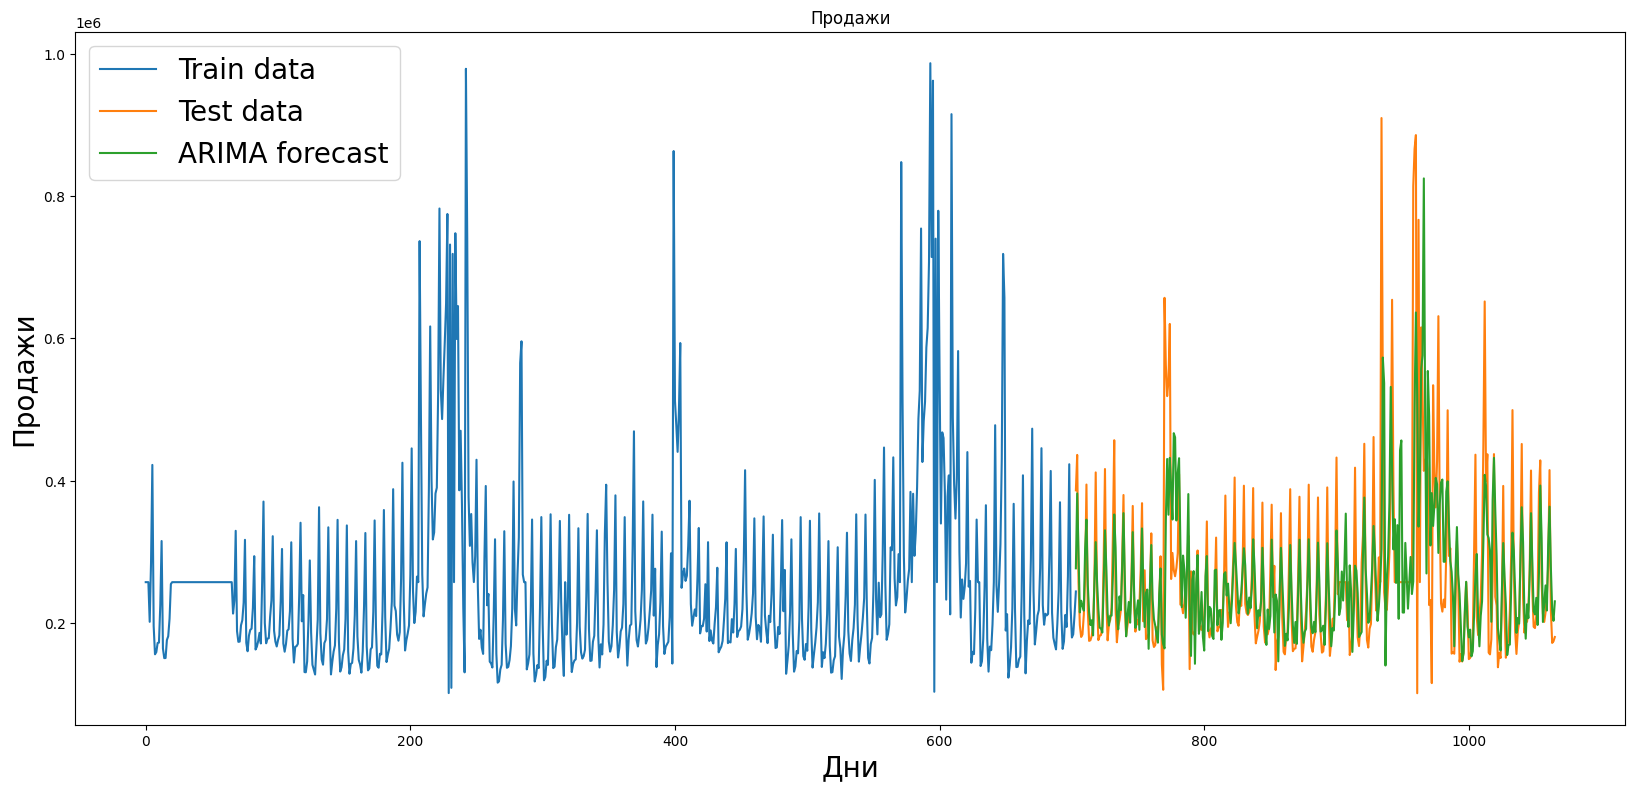

In [40]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot([i for i in range(size - 1, len(X) - 1)], arima_predictions, label='ARIMA forecast')
plt.legend(fontsize="20")
plt.title('Продажи')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

### ARIMA Metrics

In [41]:
print("RMSE:", np.sqrt(mean_squared_error(test, arima_predictions)))
print("MAPE:", mean_absolute_percentage_error(test, arima_predictions))
print("MAE:", mean_absolute_error(test, arima_predictions))
print("R2:", r2_score(test, arima_predictions))
print("SMAPE:", smape_score(test, arima_predictions))

RMSE: 98047.23633314992
MAPE: 0.22012448959772973
MAE: 59103.4987446126
R2: 0.3473045061235642
SMAPE: 0.199


Сравним значения ARMA и ARIMA

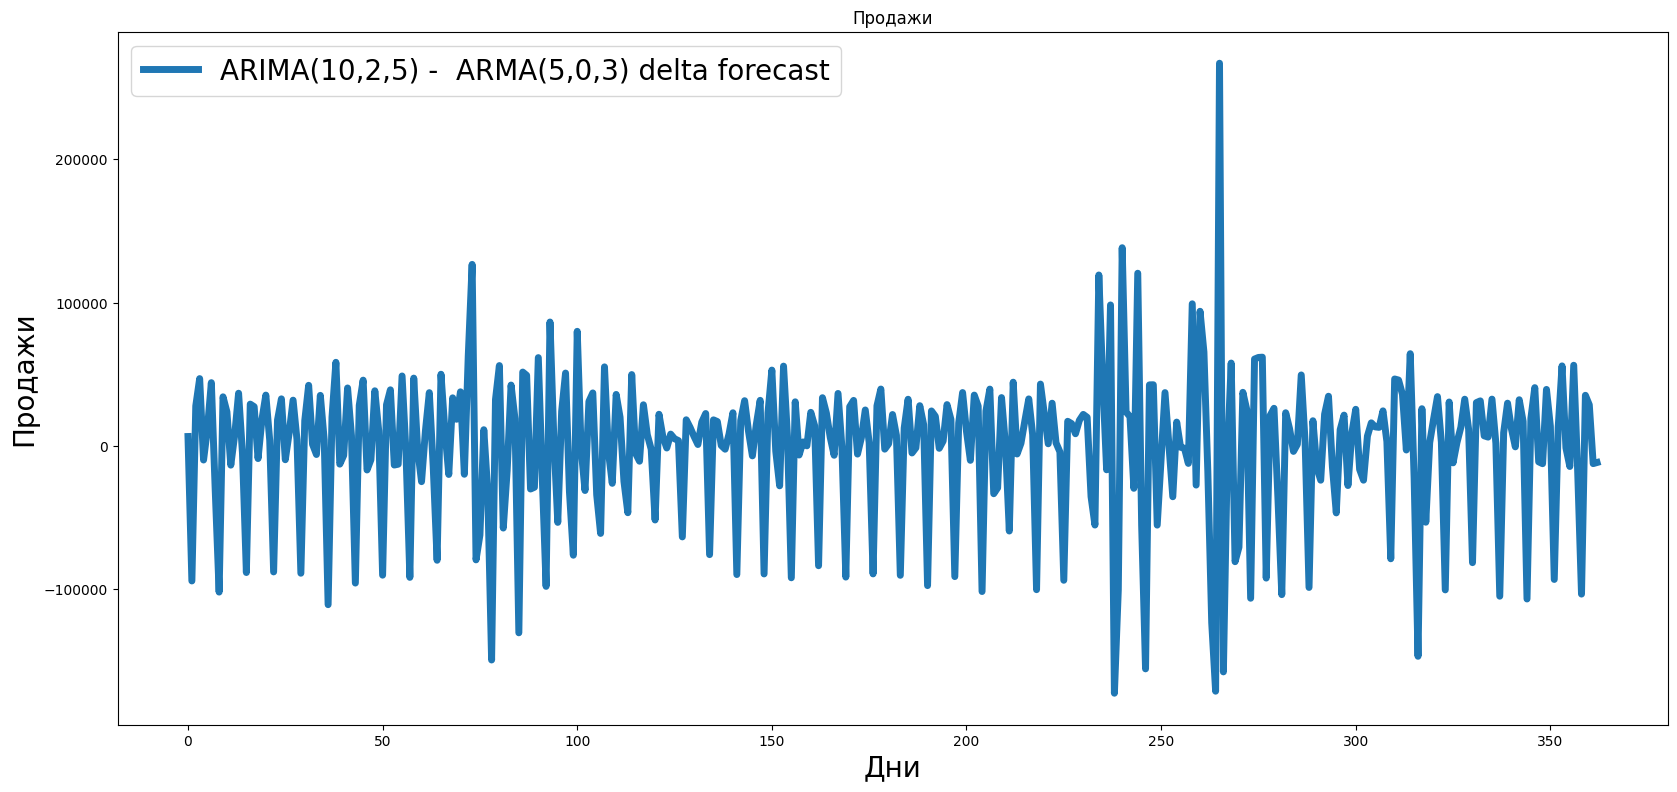

In [42]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_predictions)):
    delta.append(arma_predictions[i] - arima_predictions[i])

plt.plot(delta, label='ARIMA(10,2,5) -  ARMA(5,0,3) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Продажи')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

### Работа с пропусками данных

* Заполнение средним и медианой​
* Заполнение предыдущим и последующим значениями​
* Заполнение скользящим средним и медианой​
* Заполнение с помощью предсказания моделей машинного обучения​
* Интерполяция

Заполнение средним и медианой

<Axes: >

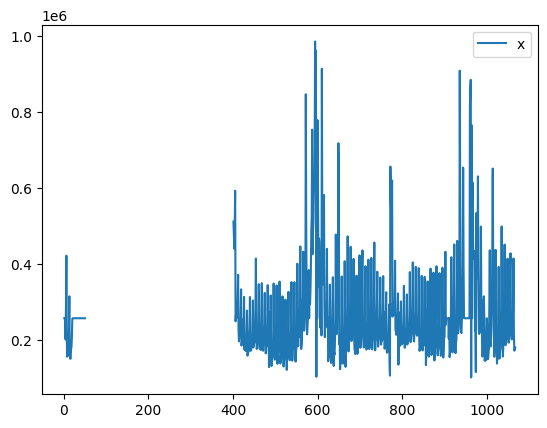

In [43]:
o_df = data.copy()

o_df["x"][50:400] = np.nan

o_df.plot()

<Axes: title={'center': 'среднее из предыдущего и последующего'}>

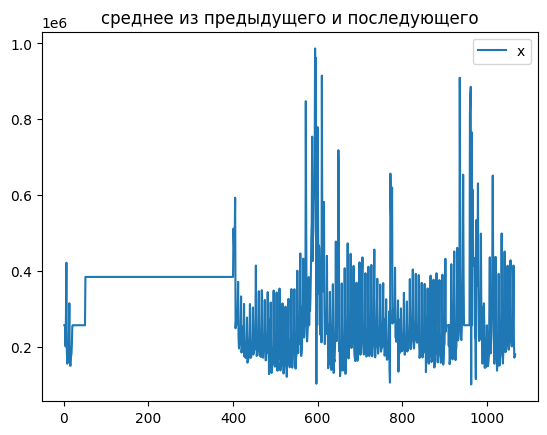

In [44]:
new_value = (o_df["x"][401] + o_df["x"][49])/2

o_df["x"][50:400] = new_value

o_df.plot(title="среднее из предыдущего и последующего")

Заполнение предыдущим и последующим значениями​

<Axes: title={'center': 'Последующее значение'}>

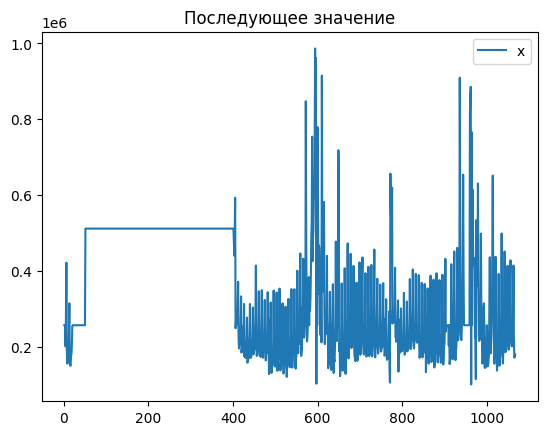

In [45]:
new_value = o_df["x"][401]

o_df["x"][50:400] = new_value

o_df.plot(title='Последующее значение')

<Axes: title={'center': 'Предыдущее значение'}>

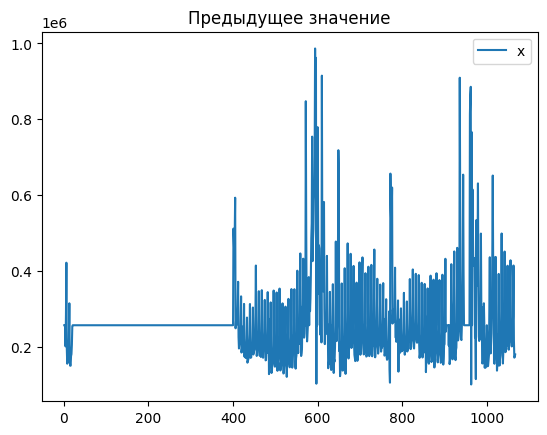

In [46]:
new_value = o_df["x"][49]

o_df["x"][50:400] = new_value

o_df.plot(title='Предыдущее значение')

Заполнение скользящим средним и медианой​

<Axes: title={'center': 'медиана'}>

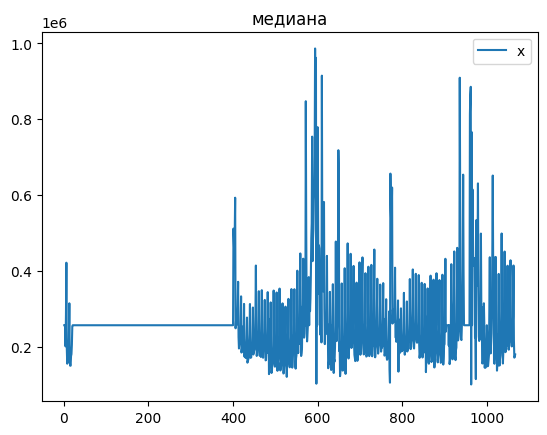

In [47]:
new_value = o_df["x"].median()

o_df["x"][50:400] = new_value

o_df.plot(title='медиана') 

<Axes: title={'center': 'среднее'}>

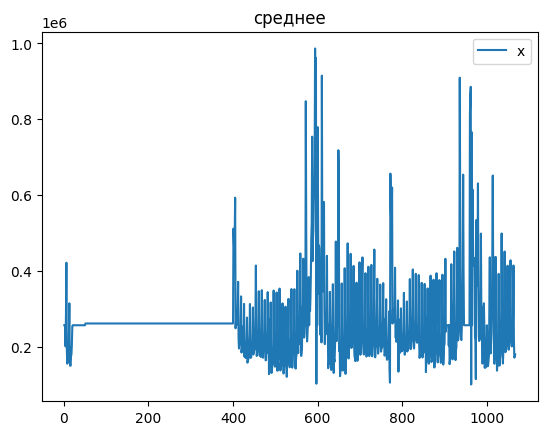

In [48]:
new_value = o_df["x"].mean()

o_df["x"][50:400] = new_value

o_df.plot(title='среднее') 

Интерполяция

<Axes: title={'center': 'zero'}>

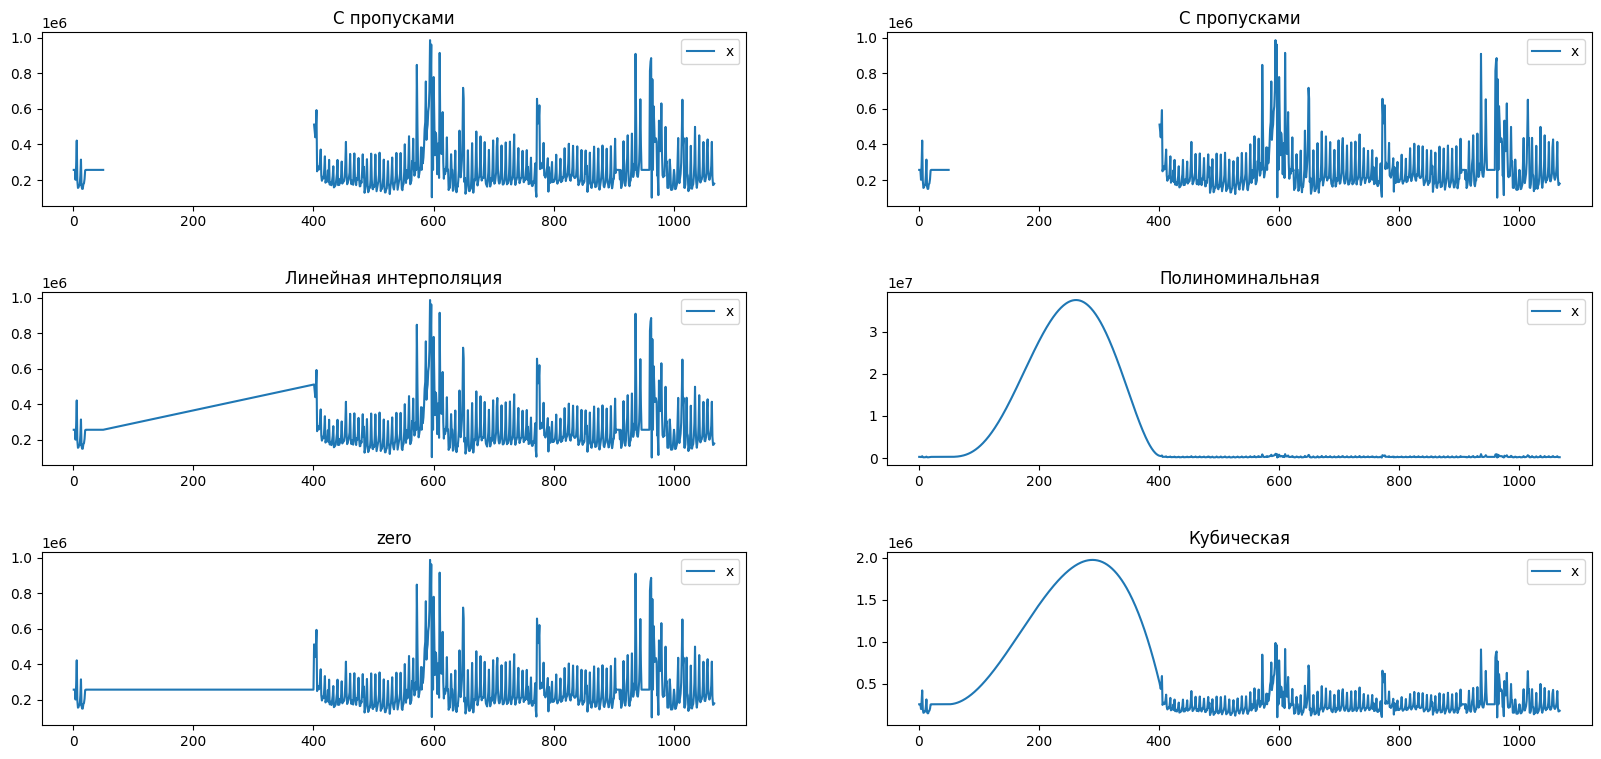

In [49]:
o_df["x"][50:400] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 
o_df.plot(title="С пропусками", ax = original_ax)  
o_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df.plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df.plot(title="Кубическая", ax = cub_ax) 
pol_df.plot(title="Полиноминальная", ax = pol_ax) 
zero_df.plot(title="zero", ax=zero_ax)


### Работа с выбросами

In [51]:
import seaborn as sns

<Axes: >

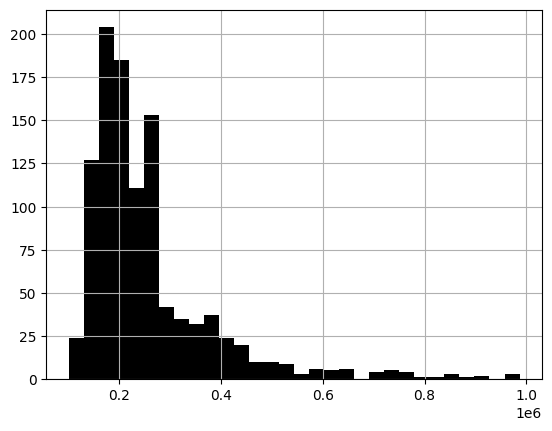

In [52]:
data["x"].hist(bins=30, color="black")

<Axes: >

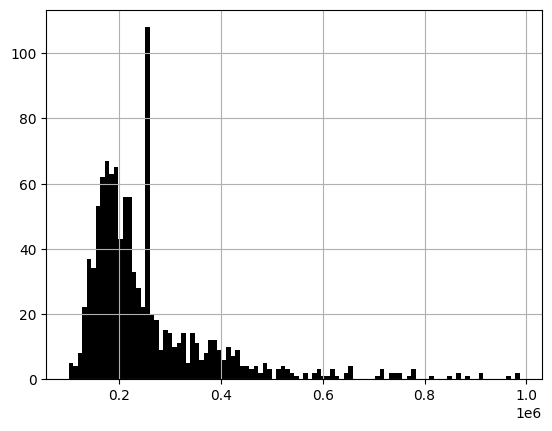

In [53]:
data["x"].hist(bins=100, color="black",)

Text(0.5, 1.0, 'x')

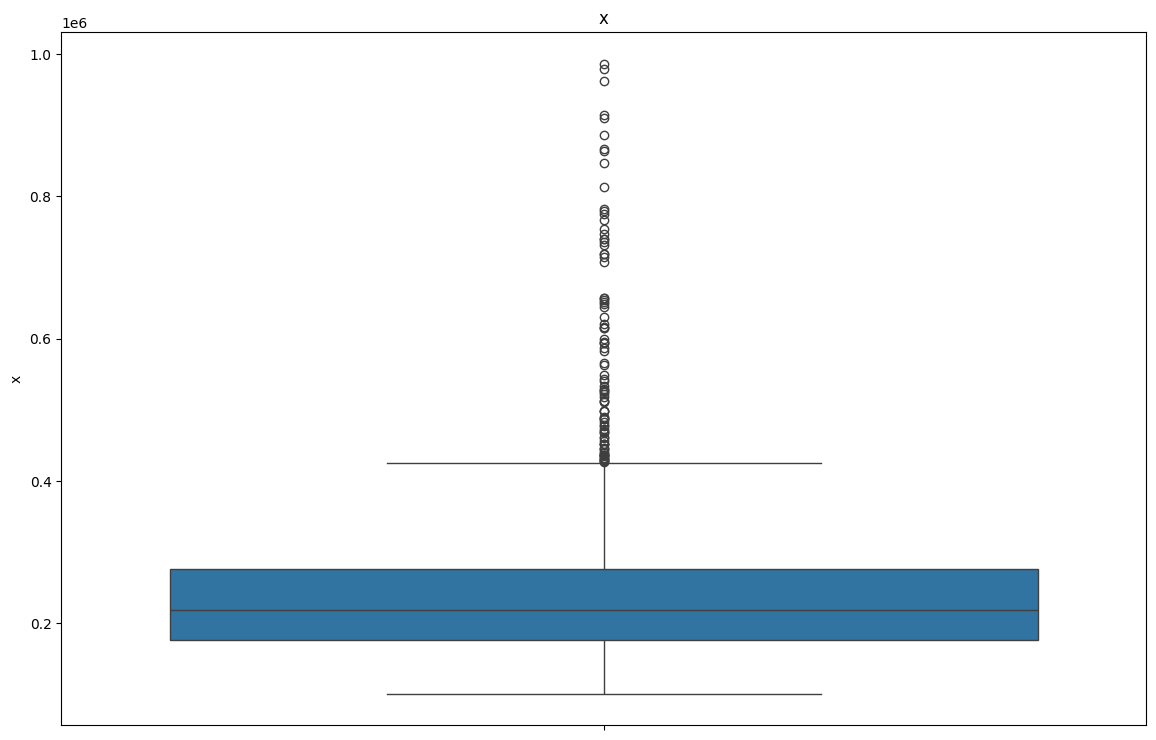

In [54]:
fig = plt.figure(figsize=(14, 9))
 
sns.boxplot(data.x).set_title('x')

Text(0.5, 1.0, 'Продажи')

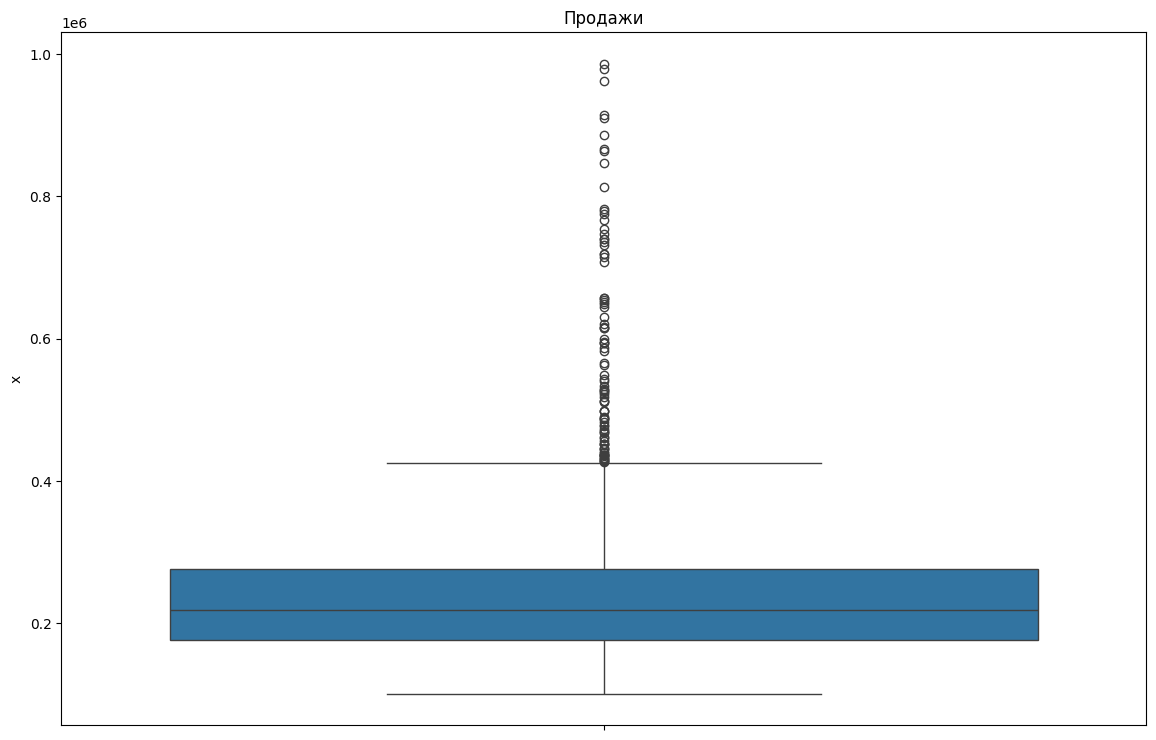

In [55]:
fig = plt.figure(figsize=(14, 9))
ax = sns.boxplot(data["x"])
ax.set_title('Продажи')

Давайте напишем функцию для автоматического обнаружения выбросов во временном ряду с использованием алгоритма кластеризации из библиотеки scikit-learn: машина векторов поддержки одного класса, она изучает границы распределения (называемые « support ») и, следовательно, может классифицировать любые точки, лежащие за пределами границы, как выбросы.

In [56]:
from sklearn import preprocessing, svm

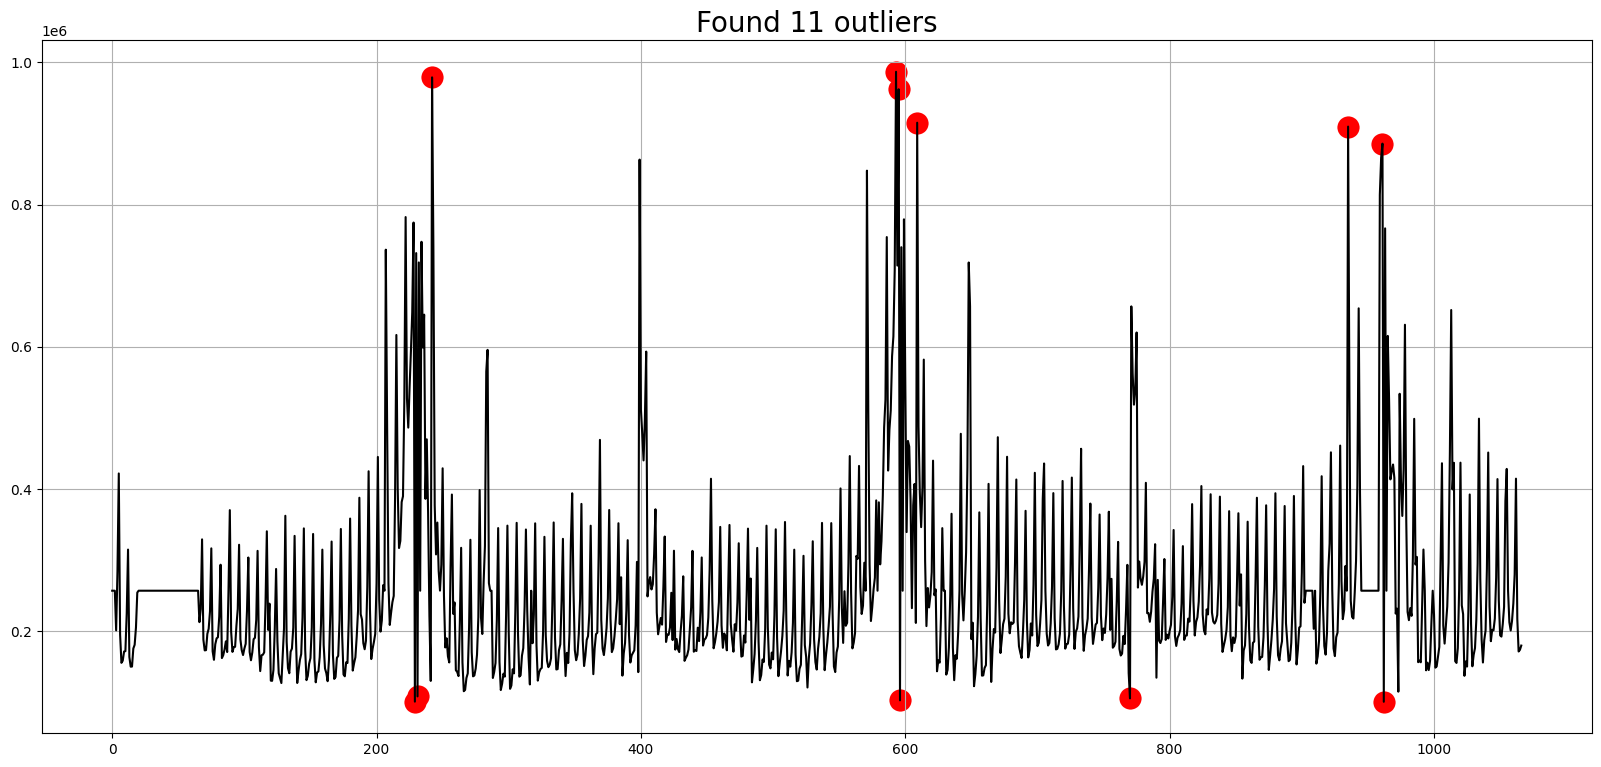

In [57]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = data["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

Но что нам делать с выбросами после обнаружения? Здесь нет оптимальной стратегии: прогнозировать временные ряды проще без точек данных, которые значительно отличаются от других наблюдений, но удаление этих точек может глубоко изменить распределение данных. Если вы решили исключить выбросы, наиболее удобный способ их удаления - интерполяция.

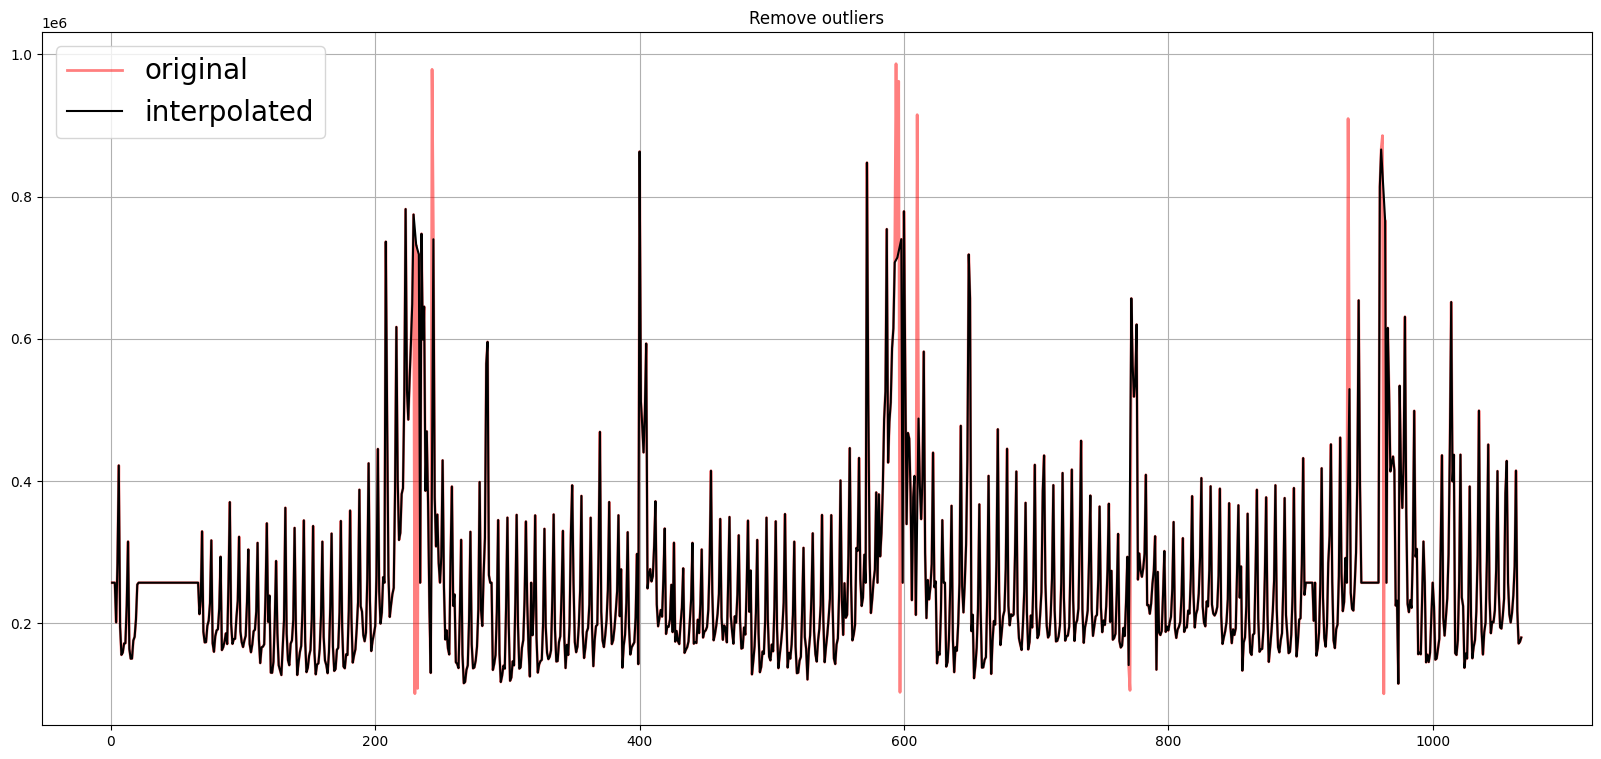

In [58]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()